## Loading Libraries

In [1]:
import pandas as pd
import glob
import os
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
import numpy as np
import warnings
from torch.utils.data import TensorDataset, DataLoader

In [2]:
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv(r"C:\Users\attafuro\Desktop\EV Charging Analysis\cleaned_traffic_data.csv")

In [4]:
df. head()

,Timestamp,Station,District,Route,Direction of Travel,Lane Type,Station Length,Samples,% Observed,Total Flow,...,Lane 5 Avg Speed,Lane 6 Flow,Lane 6 Avg Occ,Lane 6 Avg Speed,Lane 7 Flow,Lane 7 Avg Occ,Lane 7 Avg Speed,Lane 8 Flow,Lane 8 Avg Occ,Lane 8 Avg Speed
0,10/01/2024 00:00:00,308512,3,50,W,ML,3.995,197,0,497.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10/01/2024 00:00:00,311831,3,5,S,OR,NaN,101,92,27.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10/01/2024 00:00:00,311832,3,5,S,FR,NaN,101,92,78.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10/01/2024 00:00:00,311844,3,5,N,OR,NaN,202,92,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10/01/2024 00:00:00,311847,3,5,N,OR,NaN,303,92,73.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.shape

(4114680, 42)

## Basic Exploration 

In [6]:
# Define the final selected columns
selected_columns = [
    "Timestamp", "Station", "Route", "Direction of Travel",
    "Total Flow", "Avg Speed", "% Observed","Samples","Lane Type"
]

# Keep only the selected columns
df = df[selected_columns]

In [7]:
df.head()

,Timestamp,Station,Route,Direction of Travel,Total Flow,Avg Speed,% Observed,Samples,Lane Type
0,10/01/2024 00:00:00,308512,50,W,497.0,64.1,0,197,ML
1,10/01/2024 00:00:00,311831,5,S,27.0,NaN,92,101,OR
2,10/01/2024 00:00:00,311832,5,S,78.0,NaN,92,101,FR
3,10/01/2024 00:00:00,311844,5,N,43.0,NaN,92,202,OR
4,10/01/2024 00:00:00,311847,5,N,73.0,NaN,92,303,OR


In [8]:
df.isna().sum()

Timestamp                    0
Station                      0
Route                        0
Direction of Travel          0
Total Flow              303776
Avg Speed              1582594
% Observed                   0
Samples                      0
Lane Type                    0
dtype: int64

In [9]:
df.drop(columns=["Avg Speed"], inplace=True)

In [10]:
df.head()

,Timestamp,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type
0,10/01/2024 00:00:00,308512,50,W,497.0,0,197,ML
1,10/01/2024 00:00:00,311831,5,S,27.0,92,101,OR
2,10/01/2024 00:00:00,311832,5,S,78.0,92,101,FR
3,10/01/2024 00:00:00,311844,5,N,43.0,92,202,OR
4,10/01/2024 00:00:00,311847,5,N,73.0,92,303,OR


In [11]:
df.isna().sum()

Timestamp                   0
Station                     0
Route                       0
Direction of Travel         0
Total Flow             303776
% Observed                  0
Samples                     0
Lane Type                   0
dtype: int64

In [12]:
df = df[df['Total Flow'].notna()]

In [13]:
df.isna().sum()

Timestamp              0
Station                0
Route                  0
Direction of Travel    0
Total Flow             0
% Observed             0
Samples                0
Lane Type              0
dtype: int64

In [14]:
df.head()

,Timestamp,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type
0,10/01/2024 00:00:00,308512,50,W,497.0,0,197,ML
1,10/01/2024 00:00:00,311831,5,S,27.0,92,101,OR
2,10/01/2024 00:00:00,311832,5,S,78.0,92,101,FR
3,10/01/2024 00:00:00,311844,5,N,43.0,92,202,OR
4,10/01/2024 00:00:00,311847,5,N,73.0,92,303,OR


In [15]:
df.dtypes

Timestamp               object
Station                  int64
Route                    int64
Direction of Travel     object
Total Flow             float64
% Observed               int64
Samples                  int64
Lane Type               object
dtype: object

In [16]:
df.duplicated().sum()

0

In [17]:
df.reset_index().duplicated(subset=['Timestamp', 'Station']).sum()

0

In [18]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)
df.sort_index(inplace=True)

In [19]:
# Convert Station to categorical type
df['Station'] = df['Station'].astype('category')

In [20]:
df.head()

,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type
Timestamp,,,,,,,
2024-10-01,308512,50,W,497.0,0,197,ML
2024-10-01,311831,5,S,27.0,92,101,OR
2024-10-01,311832,5,S,78.0,92,101,FR
2024-10-01,311844,5,N,43.0,92,202,OR
2024-10-01,311847,5,N,73.0,92,303,OR


## Feature Engineering

In [21]:
df['Hour'] = df.index.hour
df['Day'] = df.index.day
df['Weekday'] = df.index.weekday
df['IsWeekend'] = df['Weekday'].isin([5, 6]).astype(int)

In [22]:
for lag in range(1, 73):  # Lags 1 to 72
    df[f'TotalFlow_lag_{lag}'] = df['Total Flow'].shift(lag)

# Drop the rows that now have NaNs in these lag features (first 72 rows)
df.dropna(inplace=True)

In [23]:
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Weekday_sin'] = np.sin(2 * np.pi * df['Weekday'] / 7)
df['Weekday_cos'] = np.cos(2 * np.pi * df['Weekday'] / 7)

In [24]:
df['Flow_roll_mean_6h'] = df['Total Flow'].rolling(window=6).mean()
df['Flow_roll_std_6h'] = df['Total Flow'].rolling(window=6).std()
df['Flow_roll_max_6h'] = df['Total Flow'].rolling(window=6).max()
df['Flow_roll_min_6h'] = df['Total Flow'].rolling(window=6).min()

In [25]:
for window in [3, 12, 24, 48, 72]:
    df[f'Flow_mean_{window}'] = df['Total Flow'].rolling(window=window).mean()
    df[f'Flow_std_{window}'] = df['Total Flow'].rolling(window=window).std()
    df[f'Flow_min_{window}'] = df['Total Flow'].rolling(window=window).min()
    df[f'Flow_max_{window}'] = df['Total Flow'].rolling(window=window).max()

In [26]:
df.dropna(inplace=True)

In [27]:
custom_holidays = [
    pd.to_datetime("2024-12-25"),
    pd.to_datetime("2024-12-31"),
    pd.to_datetime("2024-11-24"),
]
df['IsHoliday'] = df.index.to_series().apply(lambda x: 1 if x in custom_holidays else 0)

In [28]:
df.head()

,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type,Hour,Day,Weekday,...,Flow_max_24,Flow_mean_48,Flow_std_48,Flow_min_48,Flow_max_48,Flow_mean_72,Flow_std_72,Flow_min_72,Flow_max_72,IsHoliday
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-10-01,313344,50,W,190.0,92,202,ML,0,1,1,...,1068.0,395.833333,570.838627,3.0,3419.0,435.736111,522.596712,3.0,3419.0,0
2024-10-01,313349,50,W,190.0,92,202,ML,0,1,1,...,1068.0,399.458333,568.924516,3.0,3419.0,437.486111,521.544267,3.0,3419.0,0
2024-10-01,313368,80,W,787.0,100,719,ML,0,1,1,...,1068.0,404.375000,571.276906,3.0,3419.0,440.069444,522.824677,3.0,3419.0,0
2024-10-01,313386,80,W,1050.0,92,404,ML,0,1,1,...,1068.0,426.000000,575.736716,3.0,3419.0,443.555556,526.078366,3.0,3419.0,0
2024-10-01,313393,80,E,1064.0,92,505,ML,0,1,1,...,1068.0,376.937500,383.507686,3.0,1525.0,457.500000,529.066225,3.0,3419.0,0


In [29]:
for window in [12, 24, 48, 72]:
    df[f'Flow_CV_{window}'] = df[f'Flow_std_{window}'] / df[f'Flow_mean_{window}']

In [30]:
df.dropna(inplace=True)

In [31]:
# Group by station and calculate mean and std of Total Flow
station_stats = df.groupby('Station')['Total Flow'].agg(['mean', 'std'])
station_stats['CV'] = station_stats['std'] / station_stats['mean']
station_stats.dropna(inplace=True)  

In [32]:
df['IsHoliday'] = df['IsHoliday'].astype('category')
df['Route'] = df['Route'].astype('category')

In [33]:
#  Keep only numeric features
numeric_df = df.select_dtypes(include='number')

In [34]:
cat_features = [
    'Station', 'Route', 'Direction of Travel', 'Lane Type',
    'Weekday', 'IsWeekend', 'IsHoliday'
]

for col in cat_features:
    df[col] = df[col].astype('category')

In [35]:
# Define target and features
target = 'Total Flow'
features = [col for col in df.columns if col != target]

In [36]:
# Final feature groups
flow_features = [
    'Flow_mean_3', 'Flow_std_3', 'Flow_max_3', 'Flow_min_3',
    'Flow_mean_72', 'Flow_std_72', 'Flow_std_48', 'Flow_max_24',
    'Flow_mean_24', 'Flow_mean_48',
    'Flow_roll_std_6h', 'Flow_roll_max_6h',
    'Flow_CV_48'
]

lag_features = [
    'TotalFlow_lag_1', 'TotalFlow_lag_2', 'TotalFlow_lag_3',
    'TotalFlow_lag_7', 'TotalFlow_lag_8',
    'TotalFlow_lag_15', 'TotalFlow_lag_18'
]

time_features = [
    'Hour', 'Hour_cos', 'Hour_sin', 'Weekday_cos'
]

quality_features = [
    'Samples', '% Observed'
]

# Copy original DataFrame
df_model = df.copy()

# One-hot encode low-cardinality features
df_model = pd.get_dummies(df_model, columns=['IsHoliday', 'Direction of Travel'], drop_first=True)

# Label encode high-cardinality categorical features
for col in ['Station', 'Route', 'Lane Type']:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])

# Capture dummy columns dynamically
dummy_columns = [col for col in df_model.columns if col.startswith('IsHoliday_') or col.startswith('Direction of Travel_')]

# Final feature list
categorical_features = ['Lane Type', 'Route', 'Station']
selected_features = flow_features + lag_features + time_features + quality_features + categorical_features + dummy_columns


In [37]:
df_model.head()

,Station,Route,Total Flow,% Observed,Samples,Lane Type,Hour,Day,Weekday,IsWeekend,...,Flow_min_72,Flow_max_72,Flow_CV_12,Flow_CV_24,Flow_CV_48,Flow_CV_72,IsHoliday_1,Direction of Travel_N,Direction of Travel_S,Direction of Travel_W
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-10-01,144,7,190.0,92,202,3,0,1,1,0,...,3.0,3419.0,0.581854,0.884330,1.442119,1.199342,False,False,False,True
2024-10-01,145,7,190.0,92,202,3,0,1,1,0,...,3.0,3419.0,0.648914,0.895621,1.424240,1.192139,False,False,False,True
2024-10-01,146,11,787.0,100,719,3,0,1,1,0,...,3.0,3419.0,0.534337,0.827111,1.412740,1.188050,False,False,False,True
2024-10-01,147,11,1050.0,92,404,3,0,1,1,0,...,3.0,3419.0,0.530732,0.817180,1.351495,1.186048,False,False,False,True
2024-10-01,148,11,1064.0,92,505,3,0,1,1,0,...,3.0,3419.0,0.545745,0.772216,1.017430,1.156429,False,False,False,False


In [38]:
pivot_df = df.pivot(columns='Station', values='Total Flow')

pivot_df = pivot_df.sort_index()

In [39]:
pivot_df = pivot_df.fillna(method='ffill')       # Forward fill
pivot_df = pivot_df.fillna(method='bfill')       # Backward fill
pivot_df = pivot_df.interpolate(method='time')   # Time-based interpolation


display(pivot_df.head())

Station,308511,308512,311831,311832,311844,311847,311903,311930,311973,311974,...,3423063,3423064,3423065,3423066,3423091,3423094,3900021,3900022,3900023,3900024
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-10-01 00:00:00,12.0,489.0,24.0,44.0,25.0,59.0,1085.0,429.0,23.0,725.0,...,2.0,2632.0,2.0,3.0,75.0,0.0,556.0,320.0,546.0,320.0
2024-10-01 01:00:00,12.0,489.0,24.0,44.0,25.0,59.0,1085.0,429.0,23.0,725.0,...,3.0,2824.0,1.0,3.0,47.0,20.0,520.0,225.0,505.0,225.0
2024-10-01 02:00:00,12.0,473.0,21.0,26.0,40.0,28.0,960.0,321.0,15.0,611.0,...,3.0,3184.0,4.0,3.0,43.0,27.0,482.0,201.0,519.0,201.0
2024-10-01 03:00:00,20.0,503.0,34.0,27.0,68.0,63.0,988.0,451.0,10.0,749.0,...,2.0,3263.0,1.0,3.0,61.0,15.0,522.0,246.0,583.0,246.0
2024-10-01 04:00:00,55.0,687.0,56.0,44.0,121.0,87.0,1325.0,1059.0,24.0,1514.0,...,18.0,3654.0,6.0,3.0,153.0,79.0,649.0,446.0,915.0,446.0


In [40]:
from sklearn.preprocessing import StandardScaler
import torch

# Store index & column for future reference (optional)
index = pivot_df.index
columns = pivot_df.columns

# 1. Normalize data using StandardScaler
scaler = StandardScaler()
scaled_values = scaler.fit_transform(pivot_df.values)

# 2. Convert to tensor [T, N]
data_tensor = torch.tensor(scaled_values, dtype=torch.float32)

# 3. Optional: save scaler for inverse transform later
import joblib
joblib.dump(scaler, "flow_scaler.pkl")

# 4. Check result
print("Normalized tensor shape:", data_tensor.shape)  # should be [2208, 1806]


Normalized tensor shape: torch.Size([2208, 1806])


In [41]:
def create_X_Y_pairs(data_tensor, lag=24, horizon=12):
    T, N = data_tensor.shape
    num_samples = T - lag - horizon + 1

    X = torch.stack([data_tensor[t : t + lag] for t in range(num_samples)])
    Y = torch.stack([data_tensor[t + lag : t + lag + horizon] for t in range(num_samples)])
    return X, Y  # Shapes: [samples, lag, N], [samples, horizon, N]


In [42]:
X_12, Y_12 = create_X_Y_pairs(data_tensor, lag=24, horizon=12)
X_24, Y_24 = create_X_Y_pairs(data_tensor, lag=24, horizon=24)
X_48, Y_48 = create_X_Y_pairs(data_tensor, lag=24, horizon=48)
X_72, Y_72 = create_X_Y_pairs(data_tensor, lag=24, horizon=72)

print(f"12h: {X_12.shape}, {Y_12.shape}")
print(f"24h: {X_24.shape}, {Y_24.shape}")
print(f"48h: {X_48.shape}, {Y_48.shape}")
print(f"72h: {X_72.shape}, {Y_72.shape}")


12h: torch.Size([2173, 24, 1806]), torch.Size([2173, 12, 1806])
24h: torch.Size([2161, 24, 1806]), torch.Size([2161, 24, 1806])
48h: torch.Size([2137, 24, 1806]), torch.Size([2137, 48, 1806])
72h: torch.Size([2113, 24, 1806]), torch.Size([2113, 72, 1806])


In [43]:
def split_data(X, Y):
    total = X.shape[0]
    train_end = int(0.7 * total)
    val_end = int(0.85 * total)
    return X[:train_end], Y[:train_end], X[train_end:val_end], Y[train_end:val_end], X[val_end:], Y[val_end:]


In [44]:
X12_train, Y12_train, X12_val, Y12_val, X12_test, Y12_test = split_data(X_12, Y_12)
X24_train, Y24_train, X24_val, Y24_val, X24_test, Y24_test = split_data(X_24, Y_24)
X48_train, Y48_train, X48_val, Y48_val, X48_test, Y48_test = split_data(X_48, Y_48)
X72_train, Y72_train, X72_val, Y72_val, X72_test, Y72_test = split_data(X_72, Y_72)


In [45]:
# 12-hour
train_dataset_12 = TensorDataset(X12_train, Y12_train)
val_dataset_12 = TensorDataset(X12_val, Y12_val)
train_loader_12 = DataLoader(train_dataset_12, batch_size=64, shuffle=True)
val_loader_12 = DataLoader(val_dataset_12, batch_size=64)

# 24-hour
train_dataset_24 = TensorDataset(X24_train, Y24_train)
val_dataset_24 = TensorDataset(X24_val, Y24_val)
train_loader_24 = DataLoader(train_dataset_24, batch_size=64, shuffle=True)
val_loader_24 = DataLoader(val_dataset_24, batch_size=64)

# 48-hour
train_dataset_48 = TensorDataset(X48_train, Y48_train)
val_dataset_48 = TensorDataset(X48_val, Y48_val)
train_loader_48 = DataLoader(train_dataset_48, batch_size=64, shuffle=True)
val_loader_48 = DataLoader(val_dataset_48, batch_size=64)

# 72-hour
train_dataset_72 = TensorDataset(X72_train, Y72_train)
val_dataset_72 = TensorDataset(X72_val, Y72_val)
train_loader_72 = DataLoader(train_dataset_72, batch_size=64, shuffle=True)
val_loader_72 = DataLoader(val_dataset_72, batch_size=64)


In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class STGCN_GRU_LSTM(nn.Module):
    def __init__(self, num_nodes, input_len=24, horizon=12,
                 in_channels=1, stgcn_channels=32, gru_hidden=64, lstm_hidden=64):
        super(STGCN_GRU_LSTM, self).__init__()
        self.num_nodes = num_nodes
        self.input_len = input_len
        self.horizon = horizon

        # STGCN block
        self.stgcn = nn.Conv2d(in_channels, stgcn_channels, kernel_size=(1, 1))

        # GRU (input: [B, T, N * C])
        self.gru = nn.GRU(input_size=stgcn_channels * num_nodes,
                          hidden_size=gru_hidden, batch_first=True)

        # LSTM (input: [B, T, GRU_hidden])
        self.lstm = nn.LSTM(input_size=gru_hidden,
                            hidden_size=lstm_hidden, batch_first=True)

        # Output layer (horizon * num_nodes predictions)
        self.output_layer = nn.Linear(lstm_hidden, num_nodes * horizon)

    def forward(self, x):
        # x: [B, T, N]
        B, T, N = x.shape
        x = x.unsqueeze(1)             # [B, 1, T, N]
        x = self.stgcn(x)              # [B, C, T, N]
        x = x.permute(0, 2, 3, 1)      # [B, T, N, C]
        x = x.reshape(B, T, -1)        # [B, T, N * C]

        gru_out, _ = self.gru(x)       # [B, T, GRU_hidden]
        lstm_out, _ = self.lstm(gru_out)  # [B, T, LSTM_hidden]

        out = F.relu(lstm_out[:, -1, :])  # [B, LSTM_hidden]
        out = self.output_layer(out)     # [B, N * H]
        out = out.view(B, self.horizon, self.num_nodes)  # [B, H, N]
        return out


In [47]:
def masked_mae_loss(preds, targets):
    mask = ~torch.isnan(targets)
    loss = torch.abs(preds - targets)
    loss = loss[mask]
    return loss.mean()

def evaluate_model(model, dataloader, device):
    model.eval()
    preds, trues = [], []

    with torch.no_grad():
        for X_batch, Y_batch in dataloader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            output = model(X_batch)            # [B, H, N]
            preds.append(output.cpu().numpy())
            trues.append(Y_batch.cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    trues = np.concatenate(trues, axis=0)

    mae = mean_absolute_error(trues.flatten(), preds.flatten())
    rmse = mean_squared_error(trues.flatten(), preds.flatten(), squared=False)
    return mae, rmse


In [48]:
def train_model(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0

    for X_batch, Y_batch in dataloader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch)           # [B, H, N]
        loss = loss_fn(output, Y_batch)   # masked MAE
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


In [49]:
import torch
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

horizon_loaders = {
    12: (train_loader_12, val_loader_12),
    24: (train_loader_24, val_loader_24),
    48: (train_loader_48, val_loader_48),
    72: (train_loader_72, val_loader_72),
}

results = {}

for horizon, (train_loader, val_loader) in horizon_loaders.items():
    print(f"\n Training STGCN-GRU-LSTM for {horizon}-hour horizon")

    model = STGCN_GRU_LSTM(
        num_nodes=X12_train.shape[2],
        input_len=24,
        horizon=horizon
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(1, 21):
        train_loss = train_model(model, train_loader, optimizer, masked_mae_loss, device)
        val_mae, val_rmse = evaluate_model(model, val_loader, device)

        print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val MAE: {val_mae:.2f}, RMSE: {val_rmse:.2f}")

    # Save model & metrics
    results[horizon] = {
        "model": model,
        "val_mae": val_mae,
        "val_rmse": val_rmse,
    }
    torch.save(model.state_dict(), f"stgcn_gru_lstm_h{horizon}.pt")



 Training STGCN-GRU-LSTM for 12-hour horizon
Epoch 01 | Train Loss: 0.8264 | Val MAE: 0.76, RMSE: 0.93
Epoch 02 | Train Loss: 0.6804 | Val MAE: 0.58, RMSE: 0.78
Epoch 03 | Train Loss: 0.4929 | Val MAE: 0.42, RMSE: 0.62
Epoch 04 | Train Loss: 0.3885 | Val MAE: 0.38, RMSE: 0.60
Epoch 05 | Train Loss: 0.3653 | Val MAE: 0.35, RMSE: 0.57
Epoch 06 | Train Loss: 0.3509 | Val MAE: 0.35, RMSE: 0.56
Epoch 07 | Train Loss: 0.3441 | Val MAE: 0.34, RMSE: 0.56
Epoch 08 | Train Loss: 0.3346 | Val MAE: 0.33, RMSE: 0.54
Epoch 09 | Train Loss: 0.3239 | Val MAE: 0.32, RMSE: 0.54
Epoch 10 | Train Loss: 0.3193 | Val MAE: 0.31, RMSE: 0.54
Epoch 11 | Train Loss: 0.3118 | Val MAE: 0.31, RMSE: 0.53
Epoch 12 | Train Loss: 0.3078 | Val MAE: 0.30, RMSE: 0.52
Epoch 13 | Train Loss: 0.3025 | Val MAE: 0.30, RMSE: 0.52
Epoch 14 | Train Loss: 0.2983 | Val MAE: 0.31, RMSE: 0.52
Epoch 15 | Train Loss: 0.2995 | Val MAE: 0.31, RMSE: 0.52
Epoch 16 | Train Loss: 0.2965 | Val MAE: 0.30, RMSE: 0.52
Epoch 17 | Train Loss: 0.2

In [50]:
import joblib
scaler = joblib.load("flow_scaler.pkl")

In [51]:
def evaluate_on_test(model, X_test, Y_test, device):
    model.eval()
    with torch.no_grad():
        X_test = X_test.to(device)
        Y_test = Y_test.to(device)

        preds = model(X_test)               # [B, H, N]
        preds_np = preds.cpu().numpy()
        targets_np = Y_test.cpu().numpy()

    mae = mean_absolute_error(targets_np.flatten(), preds_np.flatten())
    rmse = mean_squared_error(targets_np.flatten(), preds_np.flatten(), squared=False)
    return preds_np, targets_np, mae, rmse


In [52]:
horizon_tests = {
    12: (X12_test, Y12_test),
    24: (X24_test, Y24_test),
    48: (X48_test, Y48_test),
    72: (X72_test, Y72_test)
}

test_metrics = {}

for horizon in [12, 24, 48, 72]:
    model = STGCN_GRU_LSTM(num_nodes=X12_train.shape[2], input_len=24, horizon=horizon).to(device)
    model.load_state_dict(torch.load(f"stgcn_gru_lstm_h{horizon}.pt"))

    X_test, Y_test = horizon_tests[horizon]
    preds, targets, mae, rmse = evaluate_on_test(model, X_test, Y_test, device)

    test_metrics[horizon] = {"mae": mae, "rmse": rmse, "preds": preds, "targets": targets}
    print(f" Horizon {horizon}h | MAE: {mae:.2f} | RMSE: {rmse:.2f}")


 Horizon 12h | MAE: 0.34 | RMSE: 0.56
 Horizon 24h | MAE: 0.36 | RMSE: 0.58
 Horizon 48h | MAE: 0.36 | RMSE: 0.58
 Horizon 72h | MAE: 0.36 | RMSE: 0.58


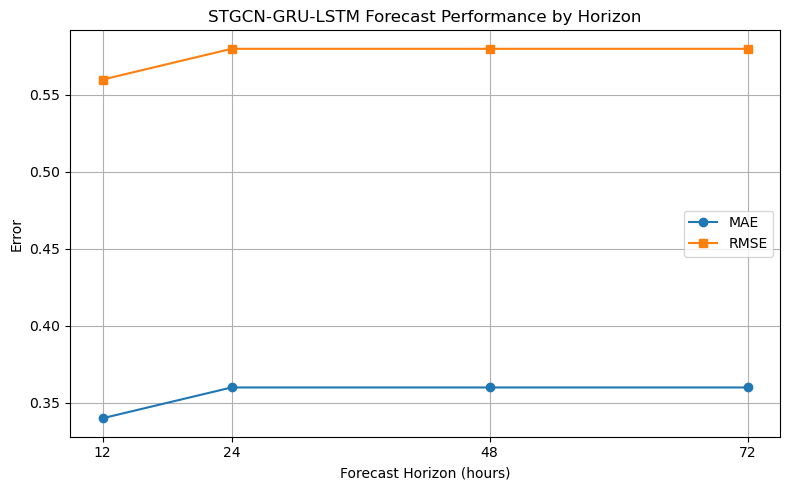

In [57]:
import matplotlib.pyplot as plt

# Collect metrics from printed results
horizons = [12, 24, 48, 72]
mae_values = [0.34, 0.36, 0.36, 0.36]
rmse_values = [0.56, 0.58, 0.58, 0.58]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(horizons, mae_values, marker='o', label='MAE')
plt.plot(horizons, rmse_values, marker='s', label='RMSE')

plt.title("STGCN-GRU-LSTM Forecast Performance by Horizon")
plt.xlabel("Forecast Horizon (hours)")
plt.ylabel("Error")
plt.xticks(horizons)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## GRU only

In [49]:
import torch.nn as nn
import torch.nn.functional as F

class GRUOnly(nn.Module):
    def __init__(self, num_nodes, input_len=24, horizon=12, hidden_dim=64):
        super(GRUOnly, self).__init__()
        self.num_nodes = num_nodes
        self.horizon = horizon

        self.gru = nn.GRU(input_size=num_nodes, hidden_size=hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, horizon * num_nodes)

    def forward(self, x):
        # x: [B, T, N]
        out, _ = self.gru(x)  # [B, T, hidden_dim]
        out = F.relu(out[:, -1, :])  # use last time step
        out = self.linear(out)       # [B, H*N]
        out = out.view(-1, self.horizon, self.num_nodes)  # [B, H, N]
        return out


In [50]:
def train_model(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0

    for X_batch, Y_batch in dataloader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch)           # [B, H, N]
        loss = loss_fn(output, Y_batch)   # masked MAE
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


In [51]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use these already defined DataLoaders:
horizon_loaders = {
    12: (train_loader_12, val_loader_12),
    24: (train_loader_24, val_loader_24),
    48: (train_loader_48, val_loader_48),
    72: (train_loader_72, val_loader_72),
}

# Dictionary to store metrics
gru_results = {}

for horizon, (train_loader, val_loader) in horizon_loaders.items():
    print(f"\n Training GRU-Only for {horizon}-hour horizon")

    model = GRUOnly(num_nodes=X12_train.shape[2], input_len=24, horizon=horizon).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(1, 21):  # 20 epochs
        train_loss = train_model(model, train_loader, optimizer, masked_mae_loss, device)
        val_mae, val_rmse = evaluate_model(model, val_loader, device)

        print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val MAE: {val_mae:.2f}, RMSE: {val_rmse:.2f}")

    # Save model and validation metrics
    gru_results[horizon] = {
        "model": model,
        "val_mae": val_mae,
        "val_rmse": val_rmse
    }

    torch.save(model.state_dict(), f"gru_only_h{horizon}.pt")



 Training GRU-Only for 12-hour horizon
Epoch 01 | Train Loss: 0.7965 | Val MAE: 0.69, RMSE: 0.88
Epoch 02 | Train Loss: 0.6033 | Val MAE: 0.50, RMSE: 0.70
Epoch 03 | Train Loss: 0.4368 | Val MAE: 0.39, RMSE: 0.60
Epoch 04 | Train Loss: 0.3640 | Val MAE: 0.36, RMSE: 0.57
Epoch 05 | Train Loss: 0.3431 | Val MAE: 0.34, RMSE: 0.55
Epoch 06 | Train Loss: 0.3268 | Val MAE: 0.33, RMSE: 0.54
Epoch 07 | Train Loss: 0.3141 | Val MAE: 0.32, RMSE: 0.53
Epoch 08 | Train Loss: 0.3049 | Val MAE: 0.31, RMSE: 0.53
Epoch 09 | Train Loss: 0.2967 | Val MAE: 0.31, RMSE: 0.51
Epoch 10 | Train Loss: 0.2900 | Val MAE: 0.30, RMSE: 0.51
Epoch 11 | Train Loss: 0.2854 | Val MAE: 0.30, RMSE: 0.50
Epoch 12 | Train Loss: 0.2782 | Val MAE: 0.29, RMSE: 0.49
Epoch 13 | Train Loss: 0.2756 | Val MAE: 0.29, RMSE: 0.50
Epoch 14 | Train Loss: 0.2693 | Val MAE: 0.29, RMSE: 0.49
Epoch 15 | Train Loss: 0.2645 | Val MAE: 0.28, RMSE: 0.49
Epoch 16 | Train Loss: 0.2602 | Val MAE: 0.28, RMSE: 0.48
Epoch 17 | Train Loss: 0.2563 | 

In [52]:
import pandas as pd

# Step 1: Build DataFrame from gru_results
gru_metrics_df = pd.DataFrame([
    {"Horizon": h, "MAE": gru_results[h]["val_mae"], "RMSE": gru_results[h]["val_rmse"]}
    for h in sorted(gru_results.keys())
])

# Optional: Print table
print(gru_metrics_df)

# Step 2: Save to Excel
gru_metrics_df.to_excel("GRU_Results.xlsx", index=False)

print("GRU-Only results saved to GRU_Results.xlsx successfully!")


   Horizon       MAE      RMSE
0       12  0.273100  0.472071
1       24  0.287443  0.492612
2       48  0.311070  0.514020
3       72  0.315275  0.522562
GRU-Only results saved to GRU_Results.xlsx successfully!


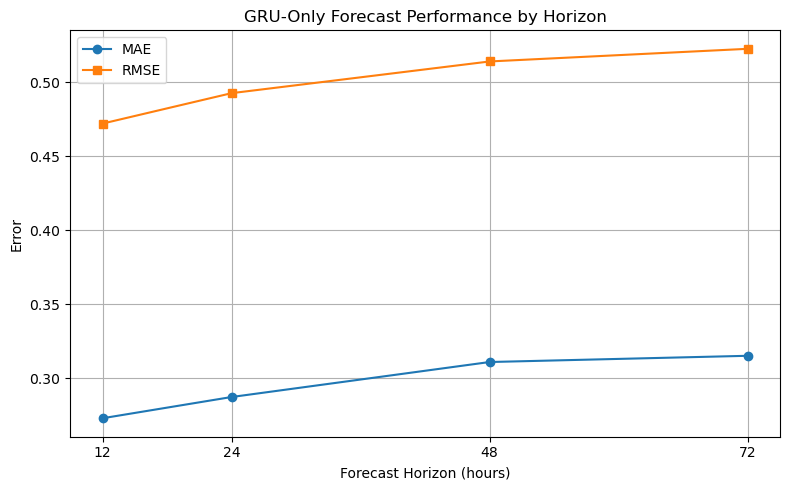

In [53]:
import matplotlib.pyplot as plt

# Ensure the DataFrame is sorted by Horizon
gru_metrics_df = gru_metrics_df.sort_values("Horizon")

# Extract values
horizons = gru_metrics_df["Horizon"].values
mae_values = gru_metrics_df["MAE"].values
rmse_values = gru_metrics_df["RMSE"].values

# Plot
plt.figure(figsize=(8, 5))
plt.plot(horizons, mae_values, marker='o', label='MAE')
plt.plot(horizons, rmse_values, marker='s', label='RMSE')

plt.title("GRU-Only Forecast Performance by Horizon")
plt.xlabel("Forecast Horizon (hours)")
plt.ylabel("Error")
plt.xticks(horizons)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
